# Background

Twitter captures real-time public opinion at massive scale, but its language is noisy (slang, emojis, repeated characters, URLs, @mentions) and unstructured, making it hard to analyze systematically. This project uses a large corpus of 1.6 million labeled tweets to design an end-to-end NLP pipeline—covering normalization, URL/emoji/mention handling, de-noising, tokenization, stopword removal, lemmatization, and TF-IDF feature construction—to enable reliable, scalable sentiment analysis on social media text.

# Problem Statement

How can we accurately and efficiently classify the sentiment (positive/negative) of incoming tweets—despite informal language, abbreviations, repeated characters, emojis, URLs, and mentions—so stakeholders can monitor public opinion at scale and over time?

# Goals

- Modeling: Deliver a robust, end-to-end sentiment classifier for tweets using TF-IDF features and evaluate SVM / LR / NB, selecting the best model on validation metrics.

- Quality: Achieve at least ~80% accuracy with balanced performance across classes (report accuracy, confusion matrix, and F1).

- Productization: Produce a clean preprocessing + inference pipeline that scores new, unseen tweets reliably.

# Importing Dependencies

In [24]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from functools import reduce

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Importing dataset
The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [3]:
dataset.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
dataset['sentiment'].unique()

array([0, 4], dtype=int64)

It contains the following 6 fields:

- sentiment: the polarity of the tweet (0 = negative, 4 = positive)
- ids: The id of the tweet (2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [6]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

In [7]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [9]:
dataset['sentiment'].unique()

array([0, 1], dtype=int64)

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

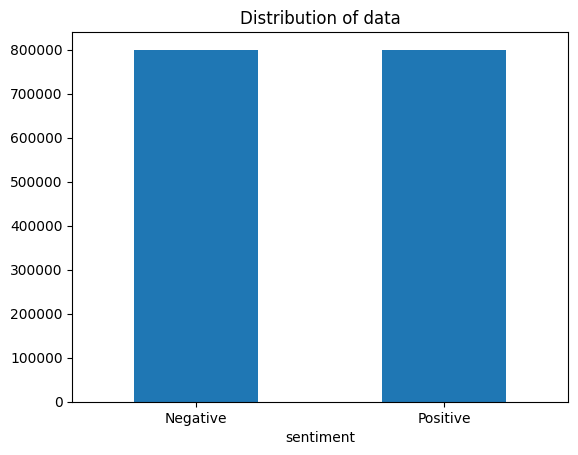

In [10]:
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

The chart shows that we have equal numbers of negative and positive tweets, which is ideal for our analysis. If there were significantly different numbers of rows in each group, we would need to take steps to balance the dataset. In our case, we can proceed with the analysis.

In [11]:
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# Preprocess Text

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

In [15]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [17]:
stopwordlist = set(stopwords.words('english'))

In [18]:
# regex stocks
url_re      = re.compile(r'(https?://\S+|www\.\S+)', flags=re.IGNORECASE)
user_re     = re.compile(r'@[^\s]+')
nonalpha_re = re.compile(r'[^a-z]+')   # leave only (a-z) alphabets
seq_re      = re.compile(r'(.)\1+')    # compress sequence words
lemm        = WordNetLemmatizer()

In [20]:
# lower casing
dataset['text_clean'] = dataset['text'].apply(lambda x: x.lower())
dataset['text_clean'].head(10)

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @kwesidei not the whole crew 
6                                          need a hug 
7    @loltrish hey  long time no see! yes.. rains a...
8                 @tatiana_k nope they didn't have it 
9                            @twittera que me muera ? 
Name: text_clean, dtype: object

In [21]:
# Replace URLs
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: url_re.sub(' URL', x))
dataset['text_clean'].head(10)

0    @switchfoot  URL - awww, that's a bummer.  you...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @kwesidei not the whole crew 
6                                          need a hug 
7    @loltrish hey  long time no see! yes.. rains a...
8                 @tatiana_k nope they didn't have it 
9                            @twittera que me muera ? 
Name: text_clean, dtype: object

In [25]:
# Replace Emojis
dataset['text_clean'] = dataset['text_clean'].apply(
    lambda x: reduce(lambda s, kv: s.replace(kv[0], 'EMOJI' + kv[1]), emojis.items(), x)
)
dataset['text_clean'].head(10)

0    @switchfoot  URL - awww, that's a bummer.  you...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @kwesidei not the whole crew 
6                                          need a hug 
7    @loltrish hey  long time no see! yes.. rains a...
8                 @tatiana_k nope they didn't have it 
9                            @twittera que me muera ? 
Name: text_clean, dtype: object

In [26]:
# Replace Usernames
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: user_re.sub(' USER', x))
dataset['text_clean'].head(10)

0     USER  URL - awww, that's a bummer.  you shoul...
1    is upset that he can't update his facebook by ...
2     USER i dived many times for the ball. managed...
3      my whole body feels itchy and like its on fire 
4     USER no, it's not behaving at all. i'm mad. w...
5                             USER not the whole crew 
6                                          need a hug 
7     USER hey  long time no see! yes.. rains a bit...
8                       USER nope they didn't have it 
9                                 USER que me muera ? 
Name: text_clean, dtype: object

In [27]:
# Remove Non-Alphabets
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: nonalpha_re.sub(' ', x))
dataset['text_clean'].head(10)

0     awww that s a bummer you shoulda got david ca...
1    is upset that he can t update his facebook by ...
2     i dived many times for the ball managed to sa...
3      my whole body feels itchy and like its on fire 
4     no it s not behaving at all i m mad why am i ...
5                                  not the whole crew 
6                                          need a hug 
7     hey long time no see yes rains a bit only a b...
8                            nope they didn t have it 
9                                        que me muera 
Name: text_clean, dtype: object

In [28]:
# Remove Consecutive Letters (heyyy → hey)
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: seq_re.sub(r'\1', x))
dataset['text_clean'].head(10)

0     aw that s a bumer you shoulda got david car o...
1    is upset that he can t update his facebok by t...
2     i dived many times for the bal managed to sav...
3       my whole body fels itchy and like its on fire 
4     no it s not behaving at al i m mad why am i h...
5                                  not the whole crew 
6                                           ned a hug 
7     hey long time no se yes rains a bit only a bi...
8                            nope they didn t have it 
9                                        que me muera 
Name: text_clean, dtype: object

In [29]:
# Remove Short Words (len < 2)
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: " ".join([w for w in x.split() if len(w) >= 2]))
dataset['text_clean'].head(10)

0    aw that bumer you shoulda got david car of thi...
1    is upset that he can update his facebok by tex...
2    dived many times for the bal managed to save t...
3        my whole body fels itchy and like its on fire
4    no it not behaving at al mad why am here becau...
5                                   not the whole crew
6                                              ned hug
7    hey long time no se yes rains bit only bit lol...
8                               nope they didn have it
9                                         que me muera
Name: text_clean, dtype: object

In [31]:
# Remove Stopwords
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: " ".join([w for w in x.split() if w not in stopwordlist]))
dataset['text_clean'].head(10)

0        aw bumer shoulda got david car third day wink
1    upset update facebok texting might cry result ...
2     dived many times bal managed save rest go bounds
3                      whole body fels itchy like fire
4                                behaving al mad se al
5                                           whole crew
6                                              ned hug
7    hey long time se yes rains bit bit lol fine th...
8                                                 nope
9                                            que muera
Name: text_clean, dtype: object

In [32]:
# Lemmatize
dataset['text_clean'] = dataset['text_clean'].apply(lambda x: " ".join([lemm.lemmatize(w) for w in x.split()]))
dataset['text_clean'].head(10)

0        aw bumer shoulda got david car third day wink
1    upset update facebok texting might cry result ...
2       dived many time bal managed save rest go bound
3                      whole body fels itchy like fire
4                                behaving al mad se al
5                                           whole crew
6                                              ned hug
7    hey long time se yes rain bit bit lol fine thanks
8                                                 nope
9                                            que muera
Name: text_clean, dtype: object

# Analysing the data
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

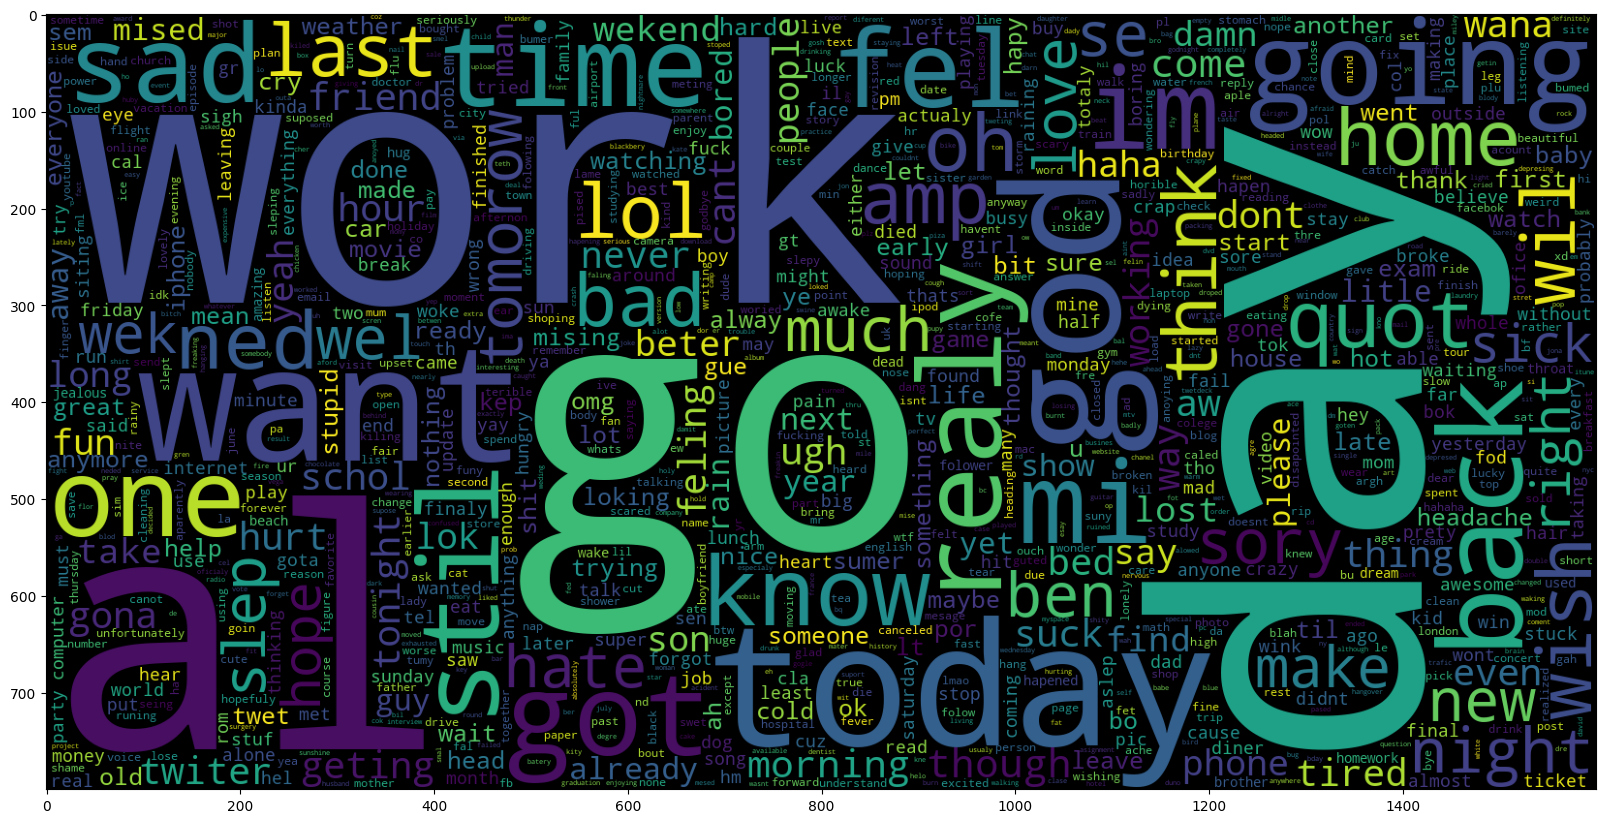

In [43]:
# Word-Cloud for Negative tweets.
data_neg = dataset['text_clean'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Based on the image, here are the main points we can conclude:

- **Most Dominant Words**: The largest and most frequent words are good, go, work, get, lol, day, and now.

- **Very Prominent Theme**: Negative Sentiment Although the word good is large, this word cloud is overwhelmingly dominated by words expressing negative sentiment, fatigue, and dissatisfaction.

- **Evidence of Negative Sentiment (Medium & Small Sized Words)**: Notice the large number of the following words that appear with high frequency:
    - **Emotions**: sad, bored, hate, cry, missed, mad.
    - **Physical/Mental State**: tired, sick, sleep, pain, hurts, headache.
    - **Negative Assessments**: bad, suck, stupid, ugh (an expression of complaint), wrong.

- **Possible Context**: The presence of words like work, school, and test surrounded by many negative words indicates this data was likely taken from **Twitter**, a place where people often complain about their day, job, or school.

**Conclusion Overall**, this word cloud depicts a collection of **tweets** where the authors frequently discuss work and daily life (day) but with a sentiment dominated by feelings of tiredness, sadness, boredom, and sickness.

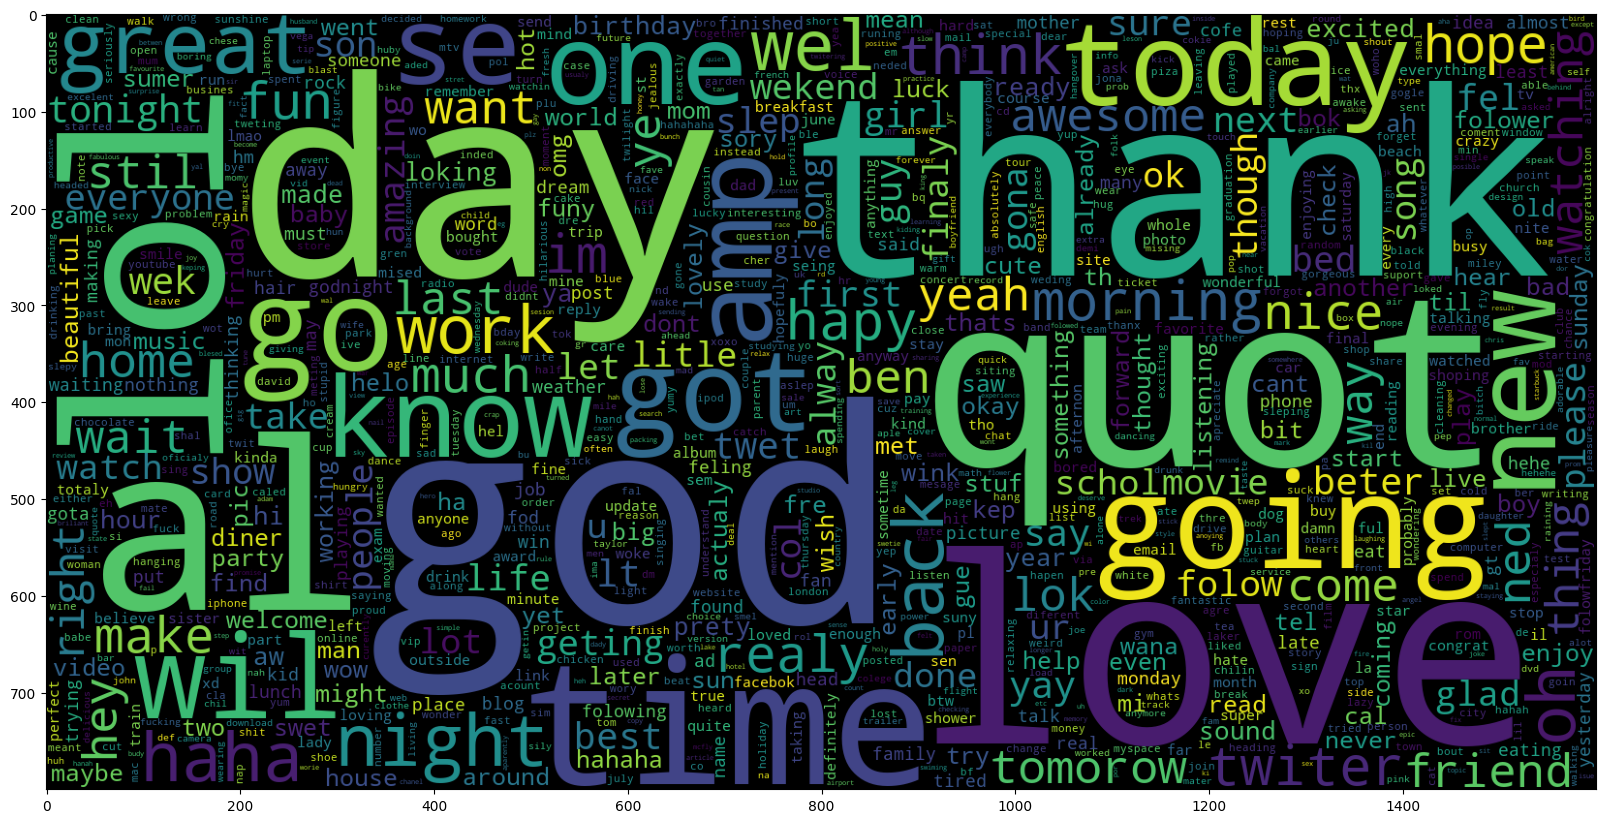

In [47]:
# Word-Cloud for Positive tweets.
data_neg = dataset['text_clean'][800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Based on the image, here are the main points we can conclude:

- **Most Dominant Words**: The most prominent and frequent words are good, love, go (or going), day, thank, and quot (most likely an abbreviation for 'quote', often appearing on Twitter).

- **Very Prominent Theme**: Positive Sentiment & Gratitude Unlike the first image, which was full of complaints, this image is filled with words expressing happiness, appreciation, and optimism.

- **Evidence of Positive Sentiment (Medium & Small Sized Words)**: A great many positive words appear:
    - **Emotions & Feelings**: happy, like, hope, glad, excited, fun.
    - **Positive Assessments**: great, awesome, nice, beautiful, best, cool, fantastic, ok.
    - **Positive Social Interactions**: thank, congrats, welcome, follow.

- **Possible Context**:
    - **Focus**: Different from the first one, the focus is not on tiring work or school, but more on social interaction (thank, love), enjoying the day (day, good, weekend), and sharing positive things on Twitter.

**Conclusion Overall**, this word cloud depicts a collection of text where users are actively sharing positive things. They are expressing gratitude, love, and happiness about their day, the weekend, and their interactions with others.

This is the **complete opposite** of the previous image, which was dominated by complaints and negative emotions.

# Splitting the Data
The Preprocessed Data is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 95% data.
- Test Data: The dataset upon which the model would be tested against. Contains 5% data.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(dataset['text_clean'], sentiment,
                                                    test_size = 0.05, random_state = 0)

# TF-IDF Vectoriser
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset**. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to **a matrix of TF-IDF features**. The Vectoriser is usually trained on only the X_train dataset.

**ngram_range** is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

**max_features** specifies the number of features to consider. [Ordered by feature frequency across the corpus].

In [52]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


# Tranforming the dataset
Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [53]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

Creating and Evaluating Models
We're creating 3 different types of model for our sentiment analysis problem:

- Bernoulli Naive Bayes (BernoulliNB)
- Linear Support Vector Classification (LinearSVC)
- Logistic Regression (LR)

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric. Furthermore, we're plotting the Confusion Matrix to get an understanding of how our model is performing on both classification types.

In [54]:
# Evaluate Model Function¶
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# BernoulliNB Model

              precision    recall  f1-score   support

           0       0.80      0.75      0.77     39989
           1       0.77      0.81      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



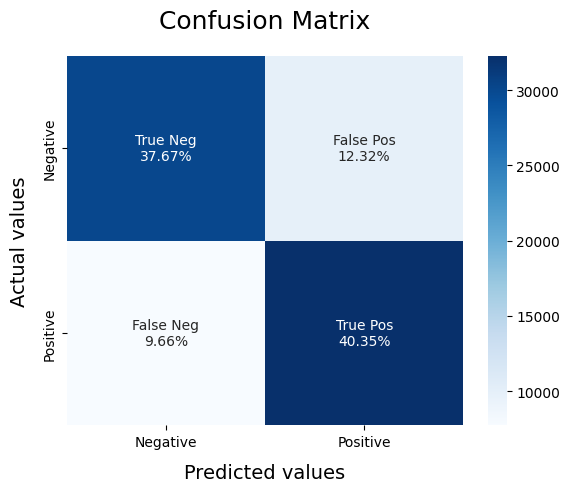

In [55]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

# LinearSVC Model

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.77      0.80      0.78     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



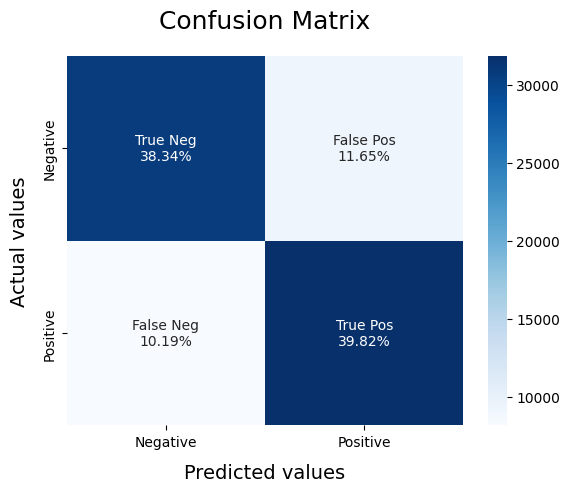

In [56]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

# Logistic Regression Model

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



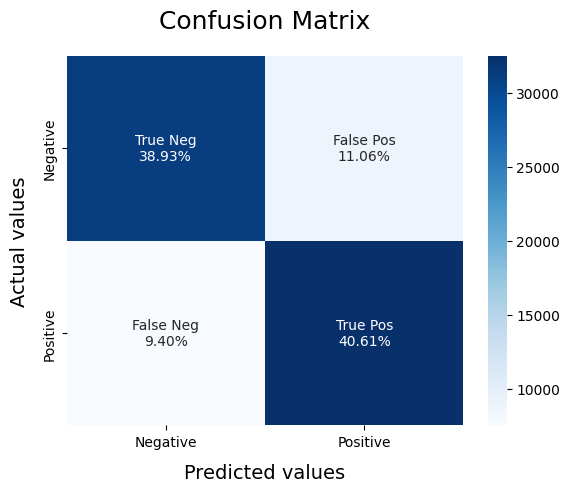

In [57]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

We can clearly see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves nearly **80% accuracy** while classifying the sentiment of a tweet.

Although it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on. It also achieves **78%** accuracy while calssifying.

# Saving the Models
We're using PICKLE to save Vectoriser and BernoulliNB, Logistic Regression Model for later use.

In [58]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

# Using the Model
To use the model for Sentiment Prediction we need to import the Vectoriser and LR Model using Pickle.

The vectoriser can be used to transform data to matrix of TF-IDF Features. While the model can be used to predict the sentiment of the transformed Data. The text whose sentiment has to be predicted however must be preprocessed.

In [61]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
           "I love working",
           "My stomatch feels hurt",
           "just watched WC2022 finals, what a game",
           "LOL, that's funny"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df)

                                      text sentiment
0                           I hate twitter  Negative
1               May the Force be with you.  Positive
2          Mr. Stark, I don't feel so good  Positive
3                           I love working  Positive
4                   My stomatch feels hurt  Negative
5  just watched WC2022 finals, what a game  Positive
6                        LOL, that's funny  Positive
